# 机器学习课程报告 K-NN Wine Quality

文档、代码合一

# 1.任务描述

（1）自己实现k-NN算法。
（2）输入葡萄酒特征（基于物理化学测试），通过自己实现的KNN算法，输出标签：葡萄酒品质（得分在 0 到 10 之间），完成对葡萄酒的品质分类。
（3）熟悉k-NN算法的原理，了解k-NN算法如何应用在真实世界问题中。

In [70]:
#导入算法包
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import operator
import pandas as pd
from matplotlib import pyplot as plt

# 2.数据集描述

采用葡萄酒数据集开展实验

In [71]:
wine_data = pd.read_csv('winequalityN.csv')#与winequalityN.csv在同一目录下
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


对数据集各列进行分析
type：类型
fixed acidity：固定酸度
volatile acidity：挥发性酸度
citric acid：柠檬酸
residual sugar：残糖
chlorides：氯化物
free sulfur dioxide：游离二氧化硫
total sulfur dioxide：二氧化硫总量
density：密度
pH：酸碱度
sulphates：硫酸盐
alcohol：酒精
quality：质量。 标签

In [72]:
wine_data.shape

(6497, 13)

查看数据集的特点，为6497行 13列数据。同时查看数据集的各项统计量

In [73]:
wine_data.info(verbose=True)#查看一下数据信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


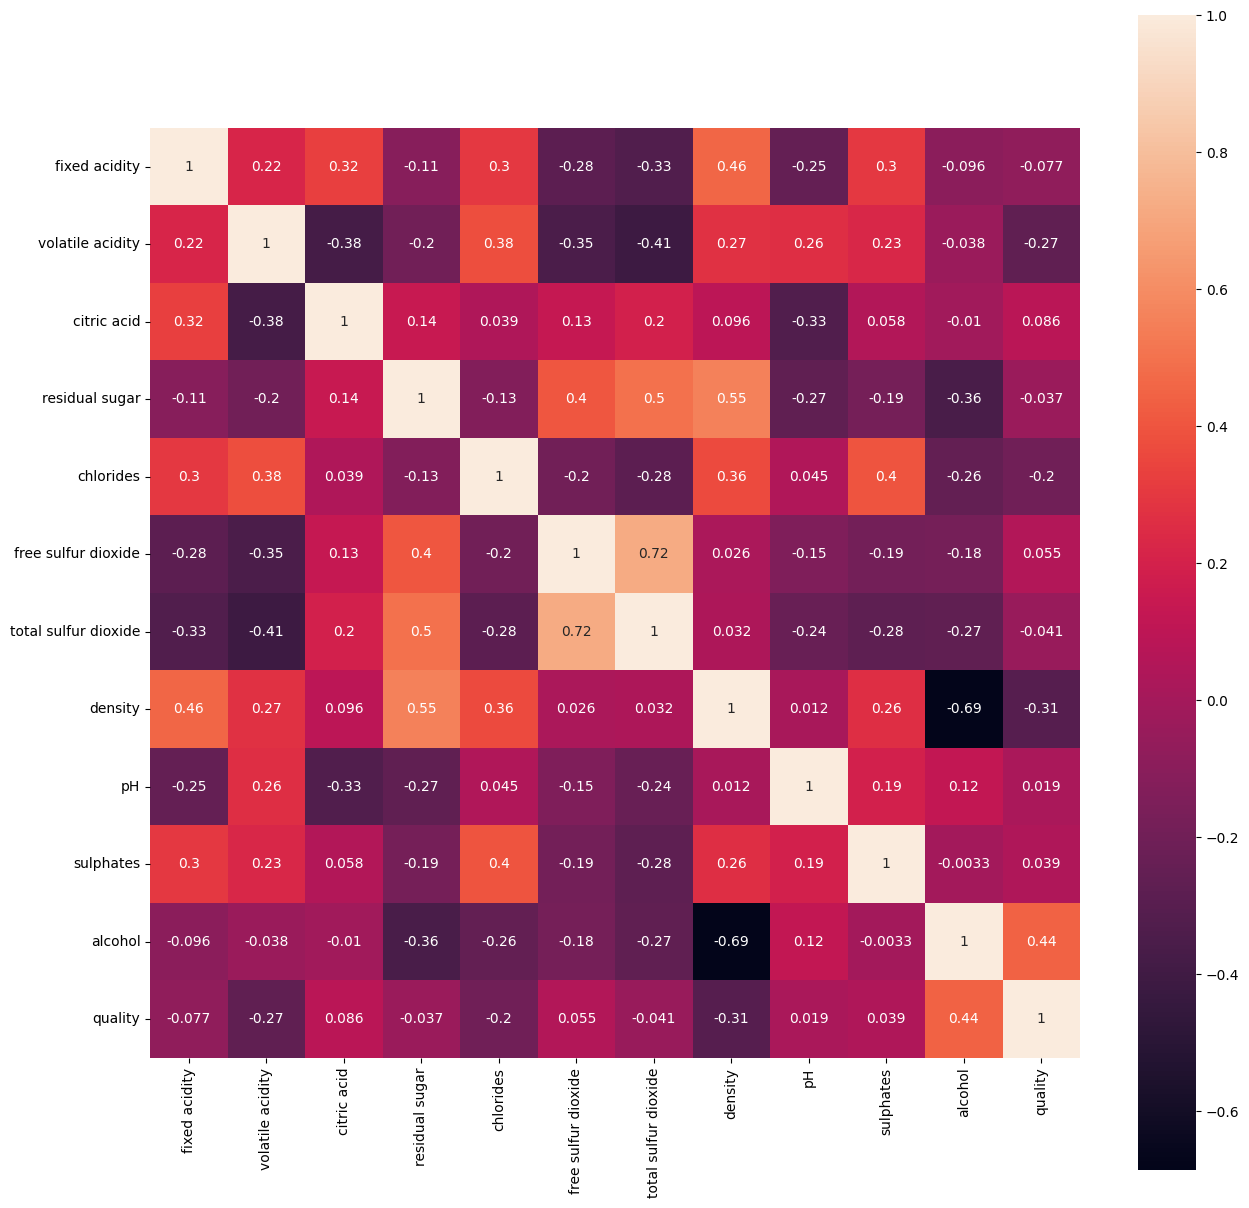

In [74]:
import seaborn as sns
plt.figure(figsize=(15,15))
s=sns.heatmap(wine_data.corr(), annot=True, square=True)

画出热力分析图，决定后续的特征值选取和数据处理的方向。数值为两个变量之间的相关系数
可以发现以目前数据分布，和quality相关系数绝对值大于0.1的有type,volatile acidity,chlorides,density,alcohol。
几乎没有与quality强相关的特质。

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


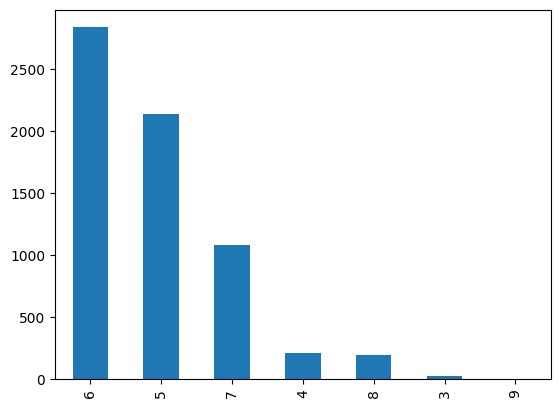

In [75]:
#查看标签分布
#标签也就是quality，也就是y。
print(wine_data.quality.value_counts())#diabetes_data.quality 获取quality(也就是标签)的值。.value_counts() 记录quality中不同值的数目
#使用柱状图的方式画出标签个数统计
p=wine_data.quality.value_counts().plot(kind='bar')#plot画图。kind='bar' 画图类型为直方图。
plt.show()

发现要求判断的葡萄酒quality（得分在 0 到 10 之间），得分集中在6分，占比高达43.7%左右；5分 6分品质葡萄酒相加占比约为76.6%。
预测的葡萄酒quality分布不均衡。

# 3.方法介绍
## 3.1数据预处理

对于非数值类型的type进行转换，把white red 编码为编号，方便后续处理

In [76]:
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()#把字符编码为编号
wine_data.iloc[:,0]=labelencoder.fit_transform(wine_data.iloc[:,0])#获取 : 所有行，0 第0列。处理完再保存
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


可以看到第0列type已经将葡萄种类换成数字表示，便于计算欧氏距离

In [77]:
labelencoder.classes_

array(['red', 'white'], dtype=object)

查看编号对应字符串，可以看出 0代表red，1代表white

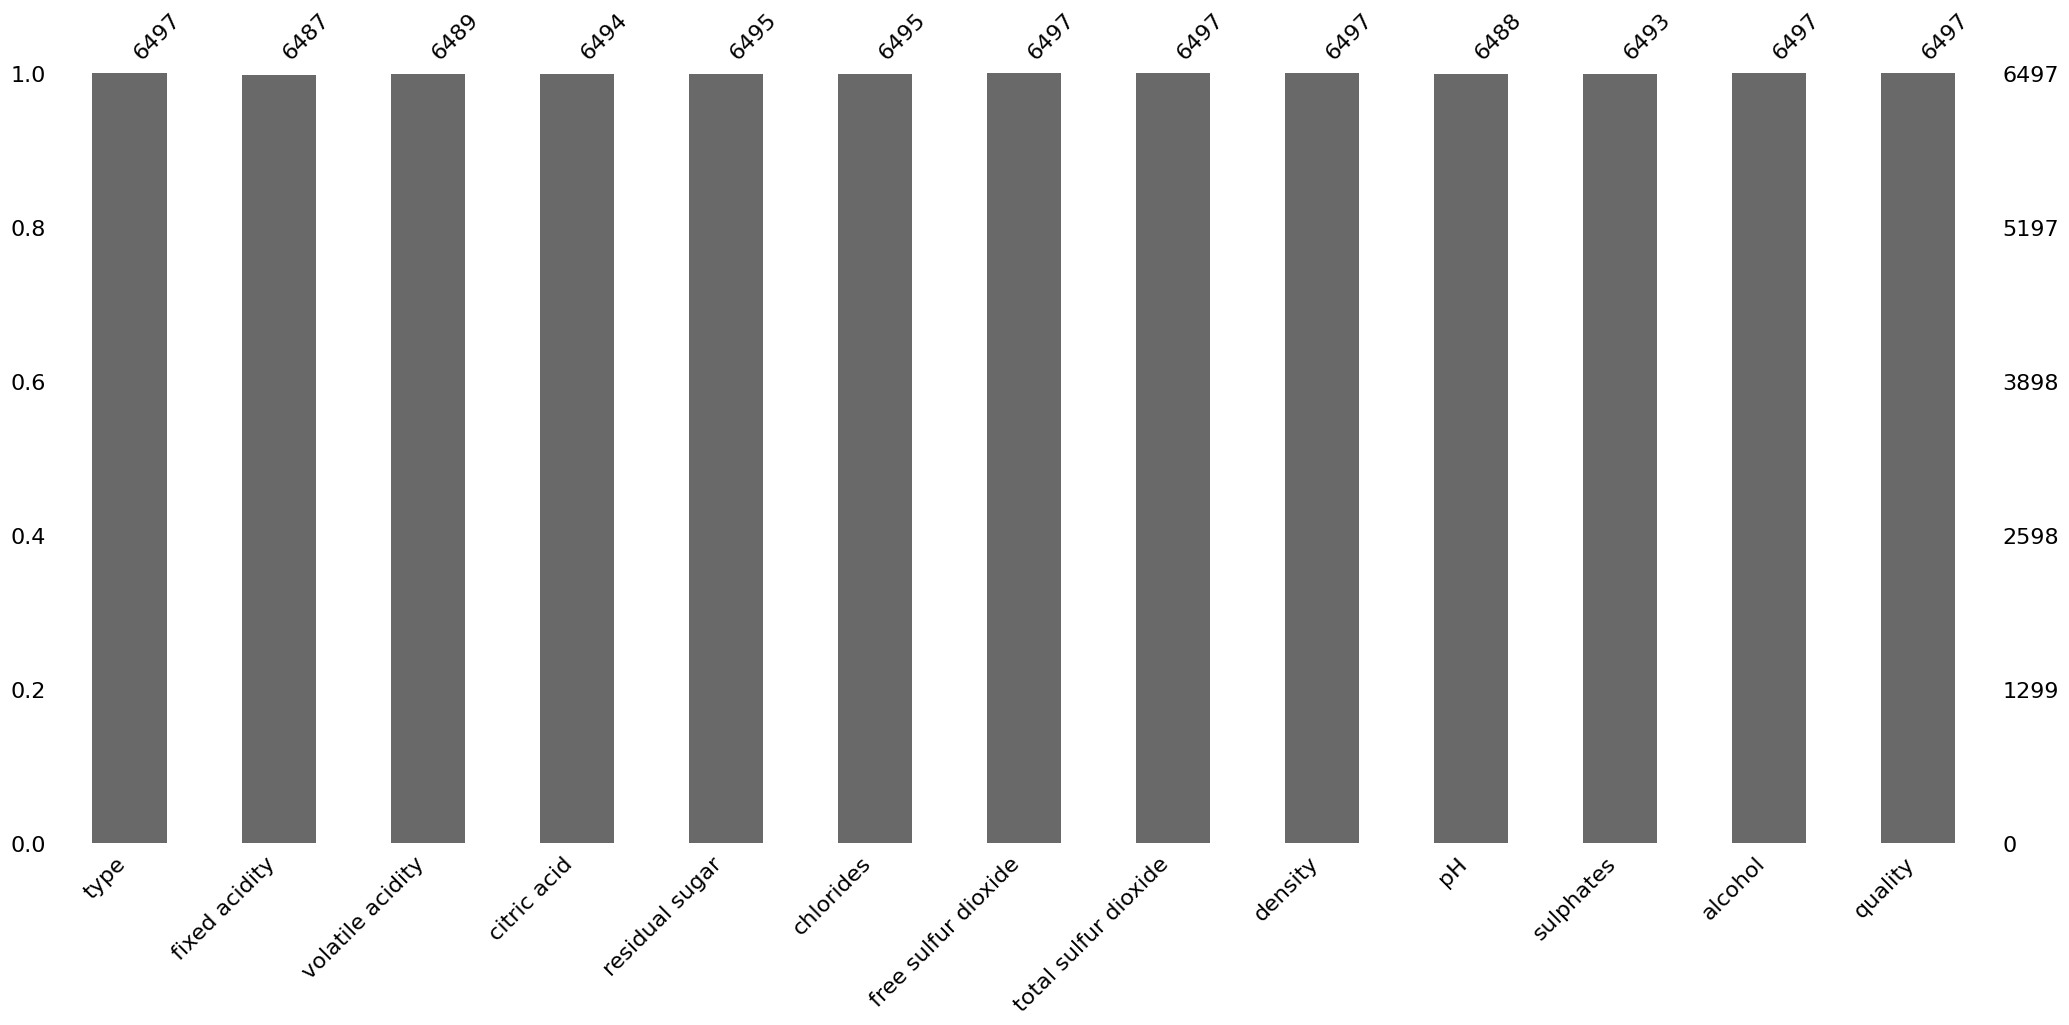

In [78]:
import missingno as msno#专门用来显示数据空值
a=msno.bar(wine_data)
plt.show()

正如我们所看到的，数据集中所有特征缺失量较小；同时数据集中有一些空值，让我们将其平均值添加到未知值中。避免对空值的计算。

In [79]:
from sklearn.impute import SimpleImputer#补其他空值
imr=SimpleImputer(strategy='mean')
colume=['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','pH','sulphates']#设置要进行空值插入的列
#进行插补
wine_data[colume]=imr.fit_transform(wine_data[colume])#fit_transform(diabetes_data[colume])取出数据进行插补，在=赋值回去

导入插补库，对数值型变量的缺失值，我们采用均值插补的方法来填充缺失值。strategy='mean'插补策略为平均值。

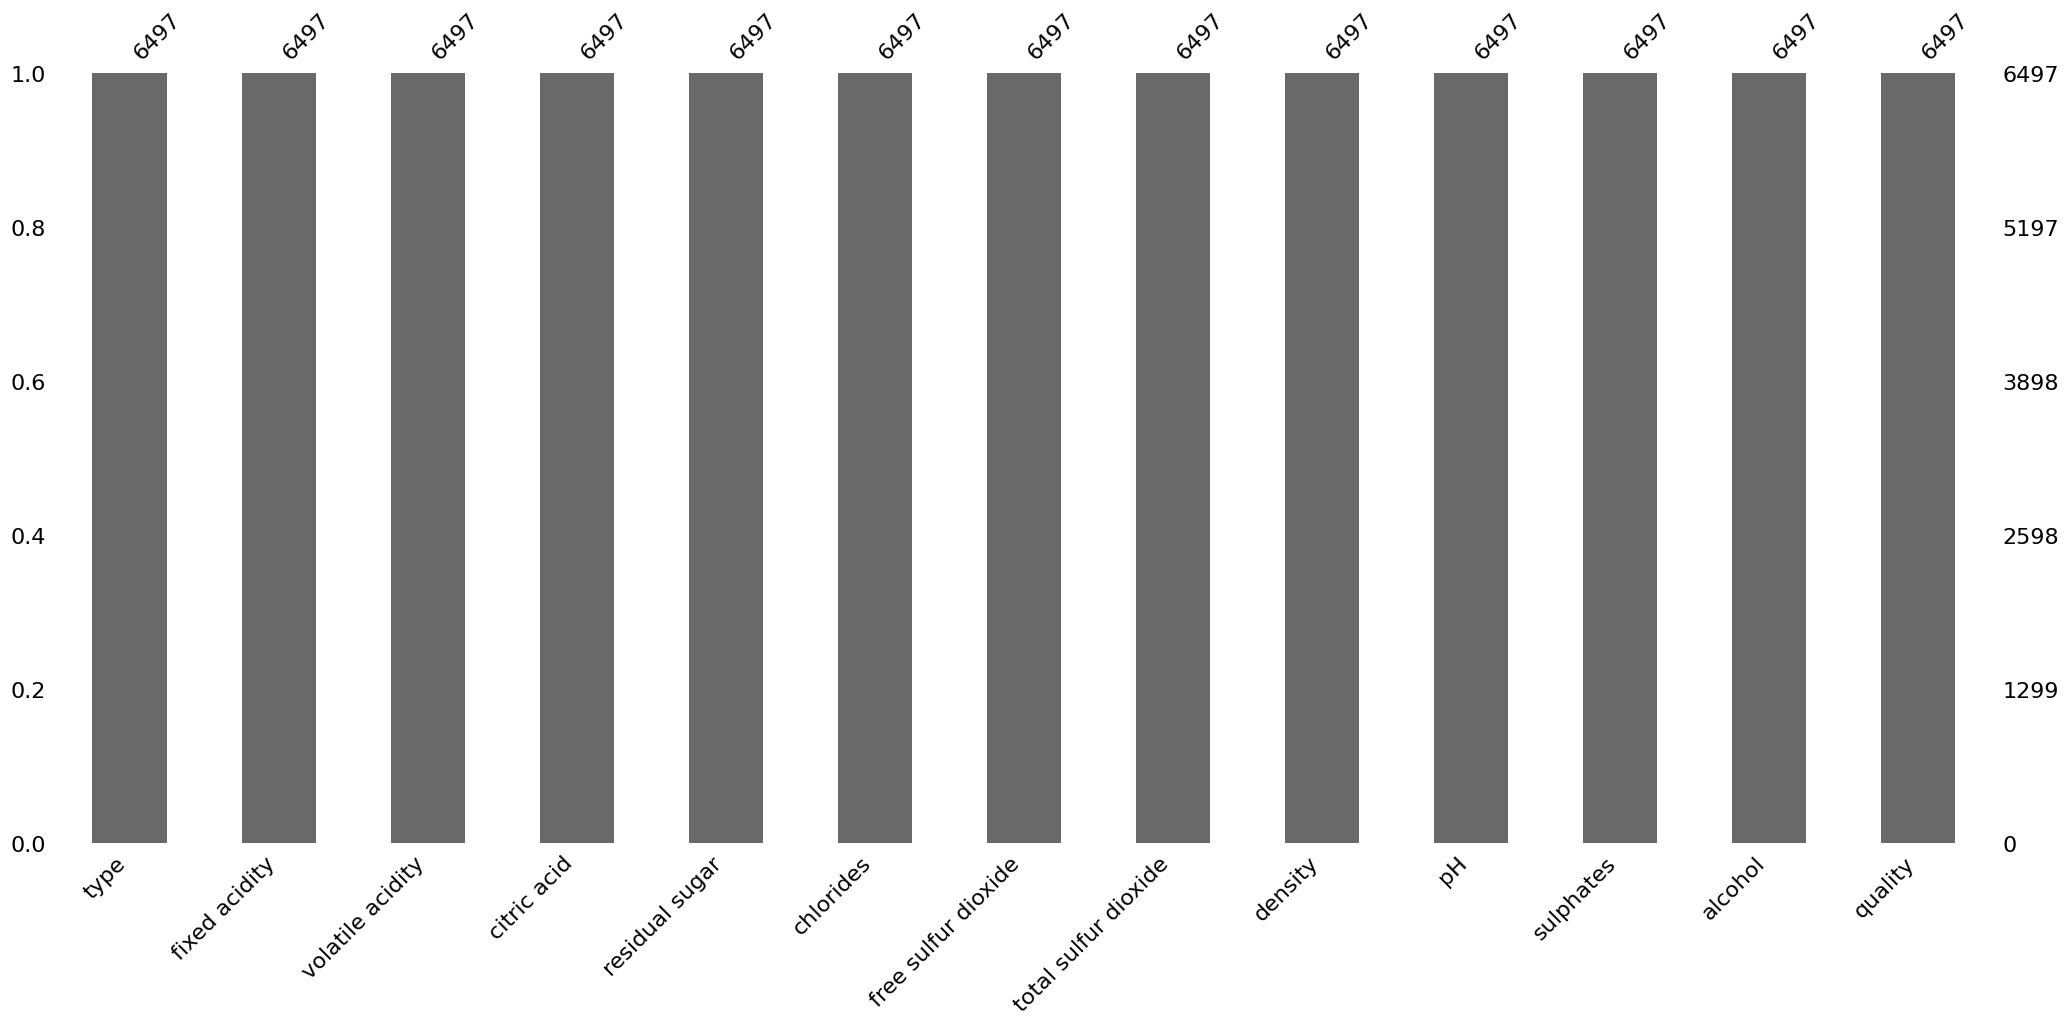

In [80]:
ms=msno.bar(wine_data)
plt.show()

插补完成，所有列均为6497个数据，没有空值。方便计算欧氏距离。

In [81]:
arr=wine_data.values
x=arr[:,:-1] #去除标签列，保存到x
y=arr[:,-1]#把标签保存到y

把数据切分为特征x和标签y。进行数据切分，将前12列切为特征，最后一列quality切为标签。
KNN算法通过利用前12列数据预测quality

In [82]:
x[:5]

array([[1.000e+00, 7.000e+00, 2.700e-01, 3.600e-01, 2.070e+01, 4.500e-02,
        4.500e+01, 1.700e+02, 1.001e+00, 3.000e+00, 4.500e-01, 8.800e+00],
       [1.000e+00, 6.300e+00, 3.000e-01, 3.400e-01, 1.600e+00, 4.900e-02,
        1.400e+01, 1.320e+02, 9.940e-01, 3.300e+00, 4.900e-01, 9.500e+00],
       [1.000e+00, 8.100e+00, 2.800e-01, 4.000e-01, 6.900e+00, 5.000e-02,
        3.000e+01, 9.700e+01, 9.951e-01, 3.260e+00, 4.400e-01, 1.010e+01],
       [1.000e+00, 7.200e+00, 2.300e-01, 3.200e-01, 8.500e+00, 5.800e-02,
        4.700e+01, 1.860e+02, 9.956e-01, 3.190e+00, 4.000e-01, 9.900e+00],
       [1.000e+00, 7.200e+00, 2.300e-01, 3.200e-01, 8.500e+00, 5.800e-02,
        4.700e+01, 1.860e+02, 9.956e-01, 3.190e+00, 4.000e-01, 9.900e+00]])

In [83]:
y[:5]

array([6., 6., 6., 6., 6.])

In [84]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
x= sc.fit_transform(x)

数据的归一化处理，欧几里得距离对幅度很敏感。对相同规模的数据进行归一化,通过归一化处理，希冀预测准确率能有所提高。

In [85]:
x[:5]

array([[1.        , 0.26446281, 0.12666667, 0.21686747, 0.30828221,
        0.05980066, 0.15277778, 0.37788018, 0.26778485, 0.21705426,
        0.12921348, 0.11594203],
       [1.        , 0.20661157, 0.14666667, 0.20481928, 0.01533742,
        0.06644518, 0.04513889, 0.29032258, 0.13283208, 0.4496124 ,
        0.15168539, 0.2173913 ],
       [1.        , 0.3553719 , 0.13333333, 0.24096386, 0.09662577,
        0.06810631, 0.10069444, 0.20967742, 0.15403894, 0.41860465,
        0.12359551, 0.30434783],
       [1.        , 0.28099174, 0.1       , 0.19277108, 0.12116564,
        0.08139535, 0.15972222, 0.41474654, 0.16367843, 0.36434109,
        0.1011236 , 0.27536232],
       [1.        , 0.28099174, 0.1       , 0.19277108, 0.12116564,
        0.08139535, 0.15972222, 0.41474654, 0.16367843, 0.36434109,
        0.1011236 , 0.27536232]])

In [86]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,stratify=y,random_state=20)#test_size=0.3测试集比例30%

划分训练集与测试集，stratify=y表示切分后训练集和测试集中的数据类型的比例和切分前y中的比例一致，比如切分前y中0和1的比例为1：2，切分后的y_train和y_test中0和1的比例也是1：2。
设置random_state，使用同样随机的方式来切分数据。方便调模型。固定随机数。

In [87]:
x_train[:5]

array([[1.        , 0.34710744, 0.22666667, 0.21686747, 0.06748466,
        0.04651163, 0.11458333, 0.21889401, 0.09427415, 0.31782946,
        0.19662921, 0.62318841],
       [0.        , 0.21487603, 0.18666667, 0.12650602, 0.02453988,
        0.06312292, 0.08680556, 0.09677419, 0.18315018, 0.58139535,
        0.30898876, 0.24637681],
       [1.        , 0.19834711, 0.08      , 0.18674699, 0.00613497,
        0.03654485, 0.07291667, 0.15437788, 0.06246385, 0.40310078,
        0.16853933, 0.47826087],
       [0.        , 0.46280992, 0.12666667, 0.31927711, 0.02760736,
        0.10797342, 0.01736111, 0.02764977, 0.17524581, 0.37209302,
        0.51123596, 0.57971014],
       [1.        , 0.18181818, 0.12666667, 0.24096386, 0.01687117,
        0.01993355, 0.05902778, 0.17511521, 0.03836514, 0.40310078,
        0.41011236, 0.74396135]])

In [88]:
x_test[:5]

array([[1.        , 0.17355372, 0.24      , 0.19879518, 0.00920245,
        0.06644518, 0.03819444, 0.25576037, 0.08155003, 0.57364341,
        0.12359551, 0.50724638],
       [1.        , 0.24793388, 0.12666667, 0.15662651, 0.23773006,
        0.06644518, 0.1875    , 0.43778802, 0.21765953, 0.33333333,
        0.15730337, 0.1884058 ],
       [1.        , 0.27272727, 0.16      , 0.20481928, 0.21319018,
        0.04983389, 0.15625   , 0.33179724, 0.15211105, 0.51162791,
        0.15730337, 0.65217391],
       [1.        , 0.29752066, 0.05333333, 0.18072289, 0.20092025,
        0.07807309, 0.11111111, 0.37327189, 0.21476769, 0.13953488,
        0.12359551, 0.10144928],
       [1.        , 0.2231405 , 0.14666667, 0.1626506 , 0.05214724,
        0.04817276, 0.125     , 0.20967742, 0.06072874, 0.37209302,
        0.21348315, 0.66666667]])

# 3.2算法描述

knn算法设计出发点：计算欧氏距离。
算法整体结构：
(1)借助欧几里得等方法计算数据样本与其他所有样本之间的距离。
(2)按升序对这些距离值进行排序。
(3)从排序的距离中选择前 K 个值。
(4)根据上述 K 值中出现频率最高的类别，将类别分配给样本。

In [89]:
#!!!k-nearest neighbor (k-NN) 算法!!!#

def knn(x_test,x_data,y_data,k):#定义knn函数#一个测试集，整体训练集数据，整体训练标签，k
    #1.计算样本数量
    x_data_size=x_data.shape[0]
    #2.复制x_test
    np.tile(x_test,(x_data_size,1))
    #3.计算x_test与每一个样本的差值
    diffMat=np.tile(x_test,(x_data_size,1))-x_data
    #4.计算差值的平方
    sqDiffMat=diffMat**2
    #4.求和
    sqDistances=sqDiffMat.sum(axis=1)
    #4.开方
    distances=sqDistances**0.5
    #5.从小到大排序
    sortedDistances=distances.argsort()
    classCount={}
    for i in range(k):
        #获取标签
        votelabel=y_data[sortedDistances[i]]
        #统计标签数量
        classCount[votelabel] = classCount.get(votelabel,0) + 1
    #6.根据operator.itemgetter(1)-第一个值对classCount排序，然后再取倒序
    sortedClassCount=sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
    #7.获取数量最多的标签
    return sortedClassCount[0][0]

算法流程：
1.计算样本数量
2.复制x_test
3.计算x_test与每一个样本的差值
4.计算差值的平方，求和，开方
5.从小到大排序
6.根据operator.itemgetter(1)-第一个值对classCount排序，然后再取倒序
7.获取数量最多的标签

可能的优化方法：
1.浓缩训练样本。当训练样本集中样本数量较大时，为了减小计算开销，可以对训练样本集进行编辑处理，即从原始训练样本集中选择最优的参考子集进行K近邻寻找，从而减少训练样本的存储量和提高计算效率。
2.算法可以去除开方distances=sqDistances**0.5过程，只是比较欧氏距离大小，开方与否不改变距离远近。
3.对训练样本库进行维护，以满足KNN算法的需要，包括对训练样本库中的样本进行添加或删除，采用适当的办法来保证空间的大小，如符合某种条件的样本可以加入数据库中，同时可以对数据库库中已有符合某种条件的样本进行删除。从而保证训练样本库中的样本提供KNN算法所需要的相对均匀的特征空间。

# 4.实验结果分析
## 4.1评价指标

Accuracy（准确率）:
分类正确的样本数 与 样本总数之比。即：(TP + TN) / ( ALL ).
Precision（精确率、查准率）:
被正确检索的样本数 与 被检索到样本总数之比。即：TP / (TP + FP).
Recall （召回率、查全率）:
被正确检索的样本数 与 应当被检索到的样本数之比。即：TP / (TP + FN).

## 4.2定量评价结果

In [90]:
predictions=[]
for i in range(x_test.shape[0]):#测试数据不能同时完成分类，一个一个来
    predictions.append(knn(x_test[i],x_train,y_train,3))

K值用于选择最近邻的数目，K的选择非常敏感。K值越小意味着模型复杂度越高，从而容易产生过拟合；K值越大则 意味着整体的模型变得简单，学习的近似误差会增大，由于数据集很小，并每次都随机选取，每次测试结果会有所变动。这里选择为3。

In [91]:
#调用sklearn中计算准确率等值的函数
print(classification_report(y_test,predictions,zero_division=0))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         9
         4.0       0.20      0.11      0.14        65
         5.0       0.59      0.60      0.60       642
         6.0       0.58      0.61      0.59       851
         7.0       0.54      0.52      0.53       324
         8.0       0.35      0.33      0.34        58
         9.0       0.00      0.00      0.00         1

    accuracy                           0.56      1950
   macro avg       0.32      0.31      0.31      1950
weighted avg       0.55      0.56      0.56      1950



如果zero_division="warn",会有警告，这是因为如果某个类别没有被预测，Macro-F1会有除0的操作。

注意：此结果由于固定随机数，故结果固定。若想随机请取消随机数固定。

accuracy约为60%，不是很高，得分集中在6分，占比高达43.7%左右。预测的葡萄酒quality分布不均衡。可能是因为新的未知实例容易被归类为这个主导样本 quality6分，这可能导致数据预测正确不高的原因之一。
precision最高为quality得分5的，为0.67。
precision最低为0，如quality得分为3的只有九个数据，被测试的quality3的葡萄酒极易被划分到其他主导的样本。
recall最高为0.68，为quality得分6分的，这也很容易理解，得分集中在6分，占比高达43.7%左右，由于是主导样本，对于未知的一个样本划入6的概率是比较大的。
recall最低为0，如3分，由于样本数过少，根本没有正确的3分葡萄酒被分回，

## 4.3可视化结果

In [92]:
print(confusion_matrix(y_test,predictions))#计算混淆矩阵

[[  0   0   6   3   0   0   0]
 [  1   7  33  21   2   1   0]
 [  0  17 388 220  17   0   0]
 [  1  10 201 517 110  12   0]
 [  0   1  26 106 168  23   0]
 [  0   0   2  23  14  19   0]
 [  0   0   0   0   1   0   0]]


该confusion_matrix()函数可用于生成混淆矩阵，以确定有多少观察被正确或错误分类。该classification_report()函数为我们提供了一些关于分类器性能的汇总统计信息。

# 5.总结
#### KNN算法优点:

(1)KNN 是一种非参数算法，因为它不对训练数据做任何假设。这使得它对于具有非线性数据的问题很有用。
(2)与其他分类算法相比，K-最近邻分类的训练阶段要快得多。无需训练模型进行泛化
(3)简单好用，容易理解，精度高，理论成熟，既可以用来做分类也可以用来做回归,对异常值不敏感。


#### KNN算法缺点:

(1)算法复杂度较高（需要比较所有已知实例与要分类的实例）
(2)当其样本分布不平衡时，比如其中一类样本过大（实例数量过多）占主导的时候，新的未知实例容易被归类为这个主导样本，因为这类样本实例的数量过大，但这个新的未知实例实际并没有接近目标样本（本次实验数据集5分 6分quality葡萄酒相加占比约为76.6%。预测的葡萄酒quality分布不均衡。可能是导致数据预测正确不高的原因之一）
(3)KNN 分类器没有任何专门的训练阶段，因为它使用所有训练样本进行分类，并将结果简单地存储在内存中。
(4)如果数据非常大，KNN 在时间和存储方面的计算成本可能很高，因为 KNN 必须存储训练数据才能工作。其他监督学习模型通常不是这种情况。
(5)KNN 对数据规模非常敏感，因为它依赖于计算距离。对于具有较高比例的要素，计算的距离可能非常高，并且可能会产生较差的结果。KNN 需要对数据进行缩放，因为 KNN 使用两个数据点之间的欧几里得距离来查找最近的邻居。欧几里得距离对幅度很敏感。

#### 本次实验总结：

1.在训练集中，有些样本可能是更值得依赖的。但我们不知道那种特征对葡萄酒quality影响更大，所有没有给不同的样本施加不同的权重，加强依赖样本的权重，降低不可信赖样本的影响。
2.分类结果易受噪声点影响，本实验只设置了k=3，因为在进行尝试时发现k=1效果最好，但k太小，分类结果易受噪声点影响，所以选择k=3.

完结撒花！！！